In [79]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import KFold
from sklearn.learning_curve import learning_curve
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
from scipy import stats
from sklearn import datasets
from sklearn import linear_model
from sklearn import feature_selection


# Studying the influence of demographics informations on the votations outcome

## Step 1 : import and select the data to use

In [2]:
# import votations outcome
vot_outcome=pd.read_csv('../Data/Votation/Results_votations',index_col=[0,1])

In [3]:
vot_outcome.loc['ZH'].head()

,Outcome,Won,Right_won,Left_won,Recom_right,Recom_left,percent_won
Unnamed: 1,,,,,,,
554,1,2,-1,1,-1,1,50.4
555,1,2,-1,1,-1,1,52.5
556,-1,2,-1,1,1,-1,61.7
557,-1,1,1,-1,-1,1,66.4
558,1,3,1,1,1,1,87.8


In [4]:
# import the demographics
demographics=pd.read_excel('../Data/Demographic/Clean/all_demographics_mean.xlsx',index_col=0,sheetname='Sheet1',header=[0])

In [5]:
# drop the rows for switzerland
demographics.drop(['Switzerland'],axis=0,inplace=True)


In [6]:
demographics.head()

,edu_expense_per_hab_2010-2012,edu_expense_percent_total_2010-2012,Age distribution in % 0–19_2014,Age distribution in % 20–64_2014,Age distribution in % 65 years or over_2014,Agricultural area Change in %_1979/85-2004/09,Agricultural area in %_2004/09,Area in km2 4)_2004/09,Arrivals in hotels and spas in 1000_2014,Average length of stay in intensive care (days)_2013,...,pop_age_total_2011-2014,pop_age_swiss_2011-2014,pop_age_foreigner_2011-2014,perm_res_2011-2014,perm_res_change_2004-2014,Single_2011-2014,Married_2011-2014,Divorced_2011-2014,Widowed_2011-2014,Proportion_female_2011-2014
ZH,4197.333333,26.666667,19.602532,63.573026,16.824443,-7.581552,41.654279,1728.85,2769.827,6.313217,...,41.296704,42.953998,36.368028,1409055.000,0.120941,0.450741,0.422531,0.085412,0.044979,0.504414
BE,3543.666667,25.000000,19.122306,60.943534,19.934160,-3.167849,42.578783,5959.40,2452.700,5.360471,...,43.087939,44.218315,36.320783,993388.500,0.045445,0.426365,0.438816,0.079606,0.057560,0.511327
LU,3492.333333,29.333333,20.829236,62.367589,16.803175,-3.962897,53.449454,1493.28,1089.328,6.212331,...,40.905594,42.078386,35.233512,386126.000,0.109032,0.457116,0.435550,0.063560,0.048224,0.504410
UR,3117.333333,22.333333,20.639858,60.186625,19.173517,-5.518644,24.176345,1076.30,134.459,5.937669,...,42.332524,42.957322,37.145483,35663.750,0.033698,0.428650,0.470036,0.045277,0.057285,0.490052
SZ,3039.666667,27.666667,20.256090,63.302981,16.440930,-3.500956,40.543815,908.03,317.623,5.020471,...,41.344154,42.505352,36.529887,149718.625,0.125042,0.436925,0.449719,0.072028,0.045372,0.488667


### select the features to drop

In [7]:
# for example decide to work only with data from 2014
#demographics=demographics[demographics.columns[demographics.columns.str.endswith('2014')]]

### Remove the row or columns with missing data

Drop the demographics that contain nans for come cantons

In [8]:
# drop the columns that contain Nans : means we dont have the info for all cantons (it removed 44 features)
demographics_clean=demographics.dropna(axis=1, how='any')

In [9]:
len(demographics.columns.tolist())-len(demographics_clean.columns.tolist())

3

In [10]:
# print the columns that were removed
print ([obj for obj in demographics.columns.tolist() if obj not in demographics_clean.columns.tolist()])

['Main language in % English_2013', 'Main language in % Italian_2013', 'Main language in % Romansh_2013']


## Step 2: Analysis of the votations as individual samples

In this step the outcome of each individual votation for each canton was analysed.

The outcomes analysed were the 4 Won classes: Right Won (1), Left Won (2), None won (0), Both won (3), or the outcome for each party individually (Right Won (-1 for no and +1 for yes) and Left Won).

The feature matrix was made of the demographics (for each canton), and the type of votation (manually classified into 8 categories: economy, education, environment, immigration, health, security, social, work.

Each sample corresponding to the result of one votation for one canton, the demographics features were repeated for all the votations (each canton always have the same features), which is not optimal.

Nevertheless we tried to analyse this whole dataset, by atempting to predict the votation outcomes based on the demographics and votation type with a RandomForrest classifier.

This was a 1st step in out analysis,to have broad idea of a potential predicting power of the demographics, but we were well aware of the limitations due to repeated features.

One way to reduce the problem would have been to have the demographics parameter of the year of each votation. This was not possible for most features because these data were not available for nost years.


### Create the feature matrix: duplicate rows and add canton and votation

1st we needed to reshape the features matrix so that it had the same shape than the votation outcomes (2 levels index: cantons and votations).

We also added the votation type and the cantons as features

In [11]:
# create a dictionnary that associates the cantons to a number
cant2nb={}
for i,cant in enumerate(pd.unique(vot_outcome.index.get_level_values(0).tolist())):
    cant2nb[cant]=i

In [15]:
# create the dictionnary to associate the votations to a certain type
import pickle
votations_sorted = pickle.load(open( "../Data/votations_sorted.p", "rb" ) )


In [16]:
votations_sorted

{'economie': [585, 587, 589, 594, 598],
 'education': [559, 563, 593],
 'environnement': [555, 556, 566, 569, 577, 578, 588, 591, 595, 599, 602],
 'immigration': [561, 571, 580, 597, 604],
 'sante': [562, 565, 573, 579, 581, 586, 592, 603],
 'securite': [554, 572, 582, 584],
 'social': [558, 560, 564, 567, 570, 576, 590, 596, 600],
 'travail': [557, 568, 574, 575, 583, 601]}

In [17]:
#associate each type of votation to a number
typevot2nb={'economie': 0,
 'education': 1,
 'environnement': 2,
 'immigration': 3,
 'sante': 4,
 'securite': 5,
 'social': 6,
 'travail': 7}

In [18]:
# find the type of each votation: create a dictionnary to associate
vot_type={}
for vot in pd.unique(vot_outcome.index.get_level_values(1).tolist()):
    vot_type[vot]=[key for key,value in votations_sorted.items() if vot in value][0]

In [19]:
typevot2nb[vot_type[554]]

5

In [20]:
# create the columns names for the feature matrix
col=demographics_clean.columns.tolist()
col.append('Canton')
#col.append('Votation')
col.append('Votation_type')

In [21]:
# create a dataframe with one row per votation for each canton
features=pd.DataFrame(index=vot_outcome.index,columns=col)

for cant in pd.unique(vot_outcome.index.get_level_values(0).tolist()):
    for vot in pd.unique(vot_outcome.index.get_level_values(1).tolist()):     
        liste=np.array(demographics_clean.loc[cant]).astype(float).tolist()
        
        #add the canton as a feature
        liste.append(cant2nb[cant])
        
        #add the votation as a feature
        #liste.append(vot)
        
        #add the type of votation as a feature
        liste.append(typevot2nb[vot_type[vot]])
        
        features.loc[(cant,vot)]=liste

### Predicting the 4 outcomes of the vote (right left both none)

##### Random forest classifier

In [22]:
# define the features and the labels
feat=np.array(features)
labels=np.array(vot_outcome['Won']) # here analyse the 4 classes outcome but could also analyse just the outcome for the
# right (Right_Won) or for the left (Left_Won)

In [23]:
# standardize the data
feat = scale(feat, axis=0, with_mean=True, with_std=True, copy=True)

/Users/lugrinclaire/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [24]:
def build_RF(n_folds, X, y, classifier):
    """
    Build random forest classifier and estimate its accuracy
    n_folds: number of folds in the crossvalidation
    X: feature matrix
    y: labels
    classifier:
    """
    #cross validation
    accuracy=[]
    folds=KFold(len(y),n_folds=n_folds,shuffle=True)
    for train_index, test_index in folds:
        X_train, X_test = X[train_index], X[test_index] # define training and testing sets
        y_train, y_test = y[train_index], y[test_index] # define labels for training and testing sets

        classifier.fit(X_train,y_train) 
        y_pred=classifier.predict(X_test)
        accuracy.append(float(sum(y_pred==y_test))/float(len(y_pred)))
    
    #classifier training
    classifier.fit(X,y) # train with all the samples
    return accuracy, classifier

def study_feature_importance(classifier,features,feat_indexes):
    """
    Study and plot the feature importances
    classifier: random forest classifier
    features: matrix of features used to train the classifier
    """
    feat_imp = classifier.feature_importances_
    n_weights = 10#np.shape(features)[1] # determine number of weights

    # Plot feature importances
    plt.figure()
    indices = np.argsort(feat_imp)[::-1]
    labels = np.array(feat_indexes)[indices][:n_weights]
    print(np.array(feat_indexes)[indices][:n_weights])
    plt.bar(range(n_weights),feat_imp[indices][:n_weights])
    plt.ylabel('Relative importance')
    plt.title('Feature Importances')
    plt.xticks(range(n_weights), labels, rotation = 'vertical')

0.443211009174 0.027828726875


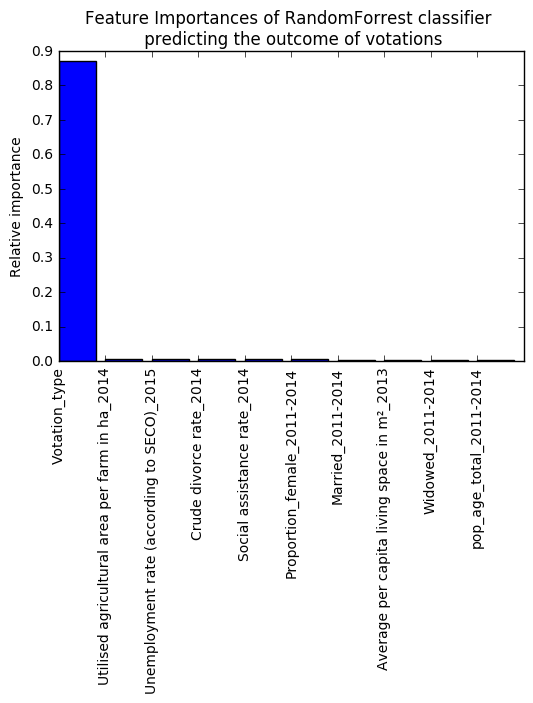

In [25]:
# Build the classifier with default parameters:
classifier = RandomForestClassifier(max_depth = None , n_estimators = 20) 

#find the index for the features
feat_indexes = features.columns.tolist()

#classify and compute accuracy
accuracy, classifier = build_RF(10,feat,labels,classifier)

# Display accuracy
mean_acc=np.mean(accuracy)
std_acc=np.std(accuracy)
print(mean_acc,std_acc)

# Study feature importance
feat_imp = classifier.feature_importances_
n_weights = 10#np.shape(features)[1] # determine number of weights

# Plot feature importances
fig=plt.figure()
indices = np.argsort(feat_imp)[::-1]
labels = np.array(feat_indexes)[indices][:n_weights]
plt.bar(range(n_weights),feat_imp[indices][:n_weights])
plt.ylabel('Relative importance')
plt.title('Feature Importances of RandomForrest classifier \n predicting the outcome of votations')
plt.xticks(range(n_weights), labels, rotation = 'vertical')
fig.savefig('../Figures/RF_allvotations.eps', format='eps')

From this we could see that only the type of votation was important to predict the outcome of the votations. The type of features (the same for each votations) used here did not allow to predict well the outcome of the votations (44% accuracy), which was expected as the data was not grouped and thus highly repeated.

Considering that the votation type seems to have a great influence on the outcome, the next step was to group the votations by type and continue the analysis on the grouped data.

# Step 2: analysis of the demographic's influence on the votations grouped in thematic categories

### Group the data by category of votations

In [26]:
#create the index of rows to keep for each votation type
idx={}
for i in np.unique(features.Votation_type):
    idx[i]=features.Votation_type==i

### Compute the cross correlation between the percentage obtained by the winning outcome and the demographics, for different categories of votations

This is a side analysis to have an idea of a potential influence on the percentage obtained by the winning outcome.

We did a cross correlation analysis separately for the different votations categories.

The outcome analysed here were again for each individual votation of the categories, an hence we still have the issue of repeated independent variable (we still have several samples for each cantons, and all samples have the same features)

We still need further averaging of the votations to bypass this issue.

In [27]:
# chose votation categorie
i=0

#build independent and dependent variable matrices
x=np.array(features[idx[i]])
y=np.array(vot_outcome['percent_won'][idx[i]])

In [28]:
# find the features significantly correlated
F, p_val=feature_selection.f_regression(x, y, center=True)

In [29]:
feat_name=features.columns.tolist()

In [30]:
significant_features=[i for i,j in zip(feat_name,p_val) if j <0.05]

In [32]:
significant_features 

['Crude mortality rate_2014',
 'Settlement and urban area Change in %_1979/85-2004/09',
 'Unproductive area in %_2004/09',
 'perm_res_change_2004-2014',
 'Widowed_2011-2014']

## Compute an average outcome for the different types of votations

To overcome the issue of repeated features across votations, we computed an average outcome of the votations of each type, for each Canton. The score was based on the number of times the right and the left won in each Canton. 

This outcome reflected the proportion of time the right group won the votation (compared to the number of time the left group won), and was computed as follows: 

$ Score = \frac{Right\ victories\ -\ Left\ victories }{number\ of\ votations} $

where Right victories correspond to the number of votations (of the type considered) that the right group won (ie. their recommendations was followed), Left victories correspond to the number of votations that the left won, and number of votations is the total number of votations of that type.

The score is positive when the right won more often, negative when the left won more often, 0 when they both won the same number of votations. An high absolute value for the score reflect to a high bias of the canton towards one of the groups (for the type of votation studied).

### Compute the scores of all votations together

In [33]:
right_won={}
left_won={}
score_right={}
score_left={}

winning_group=pd.DataFrame(index=pd.unique(vot_outcome.index.get_level_values(0).tolist()))
winning_group['All votations']=0#'Equality'#0

scores_party=pd.DataFrame(index=pd.unique(vot_outcome.index.get_level_values(0).tolist()))
scores_party['All votations']=''

for cant in pd.unique(pd.unique(vot_outcome.index.get_level_values(0).tolist())):
    right_won[cant]=sum(vot_outcome['Right_won'].loc[cant])
    left_won[cant]=sum(vot_outcome['Left_won'].loc[cant])
    
    score_right[cant]=sum(vot_outcome['Right_won'].loc[cant][vot_outcome['Right_won'].loc[cant]==1])
    score_left[cant]=sum(vot_outcome['Left_won'].loc[cant][vot_outcome['Left_won'].loc[cant]==1])
    
    # the score is the score right-score left /total number of votations
    scores_party['All votations'][cant]=(score_right[cant]-score_left[cant])/len(vot_outcome['Left_won'].loc[cant])
    
    if right_won[cant]>left_won[cant]:
        winning_group['All votations'][cant]=1#'Right'#1
    elif right_won[cant]<left_won[cant]:
        winning_group['All votations'][cant]=2#'Left'#2

    

In [34]:
typevot2str={0:'Economie',
 1:'Education',
 2:'Environnement',
 3:'Immigration',
 4:'Sante',
 5:'Securite',
 6:'Social',
 7:'Travail'}

### Compute the scores for each type of votations separated

In [35]:
# now compute for all type of votations 
for i in range(0,8):
    
    right_woni={}
    left_woni={}
    
    score_right={}
    score_left={}
    
    winning_group[typevot2str[i]]=0#'Equality'
    scores_party[typevot2str[i]]=''
    
    #keep the data of this type of votation only
    dat=vot_outcome[idx[i]]
    
    for cant in pd.unique(pd.unique(vot_outcome.index.get_level_values(0).tolist())):
        right_woni[cant]=sum(dat['Right_won'].loc[cant])
        left_woni[cant]=sum(dat['Left_won'].loc[cant])
        
        score_right[cant]=sum(dat['Right_won'].loc[cant][dat['Right_won'].loc[cant]==1])
        score_left[cant]=sum(dat['Left_won'].loc[cant][dat['Left_won'].loc[cant]==1])
    
        # the score is the score right-score left /total number of votations
        scores_party[typevot2str[i]][cant]=(score_right[cant]-score_left[cant])/len(dat['Left_won'].loc[cant])
    
        
        if right_woni[cant]>left_woni[cant]:
            winning_group[typevot2str[i]][cant]=1#'Right'
        elif right_woni[cant]<left_woni[cant]:
            winning_group[typevot2str[i]][cant]=2#'Left'

Scores for each cantons in each type of votations

In [36]:
scores_party.head()

,All votations,Economie,Education,Environnement,Immigration,Sante,Securite,Social,Travail
ZH,0.0714286,0.25,0.333333,-0.222222,0.333333,0.285714,0,-0.428571,0.6
BE,0.166667,0.25,0.333333,-0.222222,0.333333,0.285714,0.5,-0.142857,0.6
LU,0.261905,0.25,0.333333,0,0.333333,0.285714,1,-0.142857,0.6
UR,0.214286,0.25,0.333333,0,0.333333,0.285714,1,-0.142857,0.2
SZ,0.261905,0.25,0.333333,0,0.333333,0.285714,1,-0.142857,0.6


Binary score for each canton and type of votations: 
1: Right won, 2: Left won, 0: Equaility

In [37]:
winning_group.head()

,All votations,Economie,Education,Environnement,Immigration,Sante,Securite,Social,Travail
ZH,1,1,1,2,1,1,0,2,1
BE,1,1,1,2,1,1,1,2,1
LU,1,1,1,0,1,1,1,2,1
UR,1,1,1,0,1,1,1,2,1
SZ,1,1,1,0,1,1,1,2,1


In [46]:
#winning_group.to_csv('Tables/Votation/Winning_group_vot_type_str')
scores_party.to_csv('../Data/Votation/scores_party_vot_type')

In [47]:
writer = pd.ExcelWriter('../Data/Votation/scores_party_vot_type.xlsx')
scores_party.to_excel(writer,sheet_name = 'Sheet1') # table is stored in Sheet 1
writer.save()

In [48]:
#writer = pd.ExcelWriter('Tables/Votation/Winning_group_vot_type_str.xlsx')
#winning_group.to_excel(writer,sheet_name = 'Sheet1') # table is stored in Sheet 1
#writer.save()

#### Summary table of the outcomes:
Red corresponds to left won more often, blue corresponds to right won more often, grey is equality

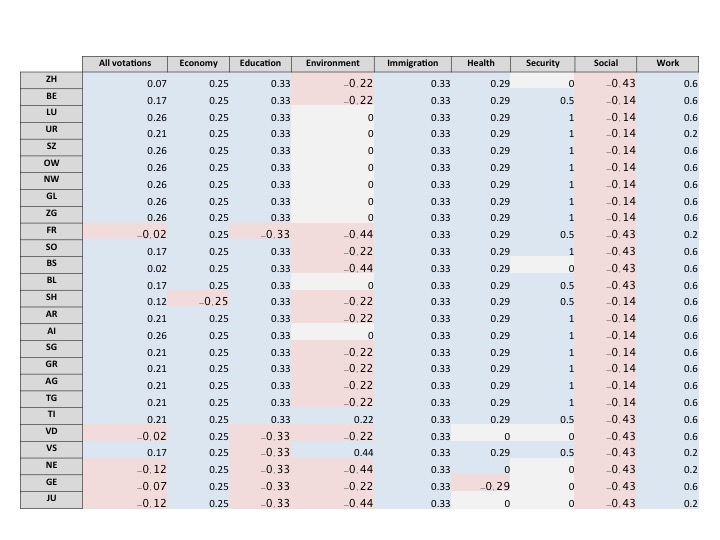

In [41]:
from IPython.display import Image
Image("../Figures/Table Scores.jpg")

From this we can already see some clear trends. For the theme of Immigration or work for example, their is a clear trend towards the right group's recommendations, whereas the recommendations of the left were mostly followed for the environmental and social votations.

We can also see that the french cantons tend to follow more often the recommendations of the left, than the other cantons.

These scores were used for further analysis. Their main advantage is that they summarised the outcomes of the votations of each type, and that thanks to these it is possible that have only one sample of each type per canton and thus avoid repeating the features.

## Clustering the type of votations based on the scores of each cantons

In this part we tried to cluster the type of votations based on the score computed before (as there seems to be some trend like the right is more followed for Immigrations or Work votations).


We used PCA to reduce the dimensionality of the features (from 26 cantons to 4 principal components), and then applied a K-means clustering. We tried different numbers of clusters.

In [60]:
from sklearn.decomposition import PCA
X=np.transpose(np.array(scores_party.drop('All votations', axis=1)).astype(float))
pca = PCA(n_components=4)
X_new=pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[ 0.77105208  0.12163461  0.05317844  0.02769304]


In [61]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_new)
kmeans.labels_

array([0, 0, 1, 0, 0, 2, 1, 0], dtype=int32)

In [62]:
colors=[]
for i in kmeans.labels_:
    if i ==0:
        colors.append('red')
    elif i==1:
        colors.append('blue')
    elif i==2:
        colors.append('green')
    else:
        colors.append('yellow')

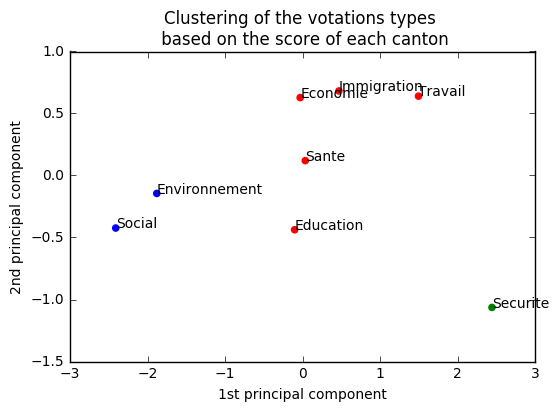

In [63]:
x=X_new[:,0]
y=X_new[:,1]
n=scores_party.drop('All votations', axis=1).columns.tolist()

fig, ax = plt.subplots()
ax.scatter(x, y,color=colors)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i],y[i]))
    
plt.title('Clustering of the votations types \n based on the score of each canton')
plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')

We see than indeed environnement and social votations cluster together (they were the ones that had a more negative (hence reflecting the left) scores. Security is a special case, as for most cantons all the recommendations fron the right group were followed, and none from the left group.

## Clustering the type of cantons based on the scores for each votation type

Similarly we clustered the Cantons based on their votation scores in the 8 different categories.

We used the same methods (PCA, keeping the 4 1st prinicpal components, K-means clustering) and tried different numbers of clusters.

In [64]:
#drop the columns that had all votations
X=np.array(scores_party.drop('All votations', axis=1)).astype(float)

In [65]:
pca = PCA(n_components=4)
X_new=pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[ 0.679326    0.13626998  0.09190749  0.04231283]


In [66]:
sum(pca.explained_variance_ratio_)

0.94981630733183608

In [67]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_new)
kmeans.labels_

array([3, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 0, 0, 2, 2, 2, 2, 2, 2, 0, 1, 4,
       1, 1, 1], dtype=int32)

In [68]:
colors=[]
for i in kmeans.labels_:
    if i ==0:
        colors.append('red')
    elif i==1:
        colors.append('blue')
    elif i==2:
        colors.append('green')
    elif i==3:
        colors.append('orange')
    else:
        colors.append('yellow')
        

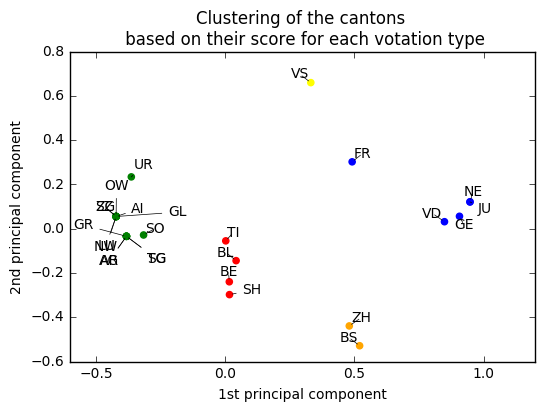

In [69]:
from adjustText import adjust_text
x=X_new[:,0]
y=X_new[:,1]
n=scores_party.drop('All votations', axis=1).index.tolist()

fig, ax = plt.subplots()
ax.scatter(x, y,color=colors)
texts = []
for xt, yt, s in zip(x, y, n):
        texts.append(plt.text(xt, yt, s))
#for i, txt in enumerate(n):
#    ax.annotate(txt, (x[i],y[i]))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
plt.title('Clustering of the cantons \n based on their score for each votation type')
plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')

fig.savefig('../Figures/Cluster_cantons_pervottype.eps', format='eps')

Interestingly, the cantons that are french speaking (blue cantons: Geneve, Jura, Neuchatel, Vaud and a part of Fribourg) clustered together. This reflects the cultural difference in Switzerland, than can be detected in the way people vote.

## Analysis of the correlations between the demographics and the scores for each type of votations

With the score computed above we can test the correlation between the demographic features ofeahc canton and their score in the respective votations categories.

We used a cross correlation test, to compute the regression coefficients between the demographics and the votations scores (for all votations or each votation types separately). The demographic parameters for which the p-value of the correlation was lower than 0.01 were considered being significantly correlated with the votations outcome

In [70]:
demographics_clean.head()

,edu_expense_per_hab_2010-2012,edu_expense_percent_total_2010-2012,Age distribution in % 0–19_2014,Age distribution in % 20–64_2014,Age distribution in % 65 years or over_2014,Agricultural area Change in %_1979/85-2004/09,Agricultural area in %_2004/09,Area in km2 4)_2004/09,Arrivals in hotels and spas in 1000_2014,Average length of stay in intensive care (days)_2013,...,pop_age_total_2011-2014,pop_age_swiss_2011-2014,pop_age_foreigner_2011-2014,perm_res_2011-2014,perm_res_change_2004-2014,Single_2011-2014,Married_2011-2014,Divorced_2011-2014,Widowed_2011-2014,Proportion_female_2011-2014
ZH,4197.333333,26.666667,19.602532,63.573026,16.824443,-7.581552,41.654279,1728.85,2769.827,6.313217,...,41.296704,42.953998,36.368028,1409055.000,0.120941,0.450741,0.422531,0.085412,0.044979,0.504414
BE,3543.666667,25.000000,19.122306,60.943534,19.934160,-3.167849,42.578783,5959.40,2452.700,5.360471,...,43.087939,44.218315,36.320783,993388.500,0.045445,0.426365,0.438816,0.079606,0.057560,0.511327
LU,3492.333333,29.333333,20.829236,62.367589,16.803175,-3.962897,53.449454,1493.28,1089.328,6.212331,...,40.905594,42.078386,35.233512,386126.000,0.109032,0.457116,0.435550,0.063560,0.048224,0.504410
UR,3117.333333,22.333333,20.639858,60.186625,19.173517,-5.518644,24.176345,1076.30,134.459,5.937669,...,42.332524,42.957322,37.145483,35663.750,0.033698,0.428650,0.470036,0.045277,0.057285,0.490052
SZ,3039.666667,27.666667,20.256090,63.302981,16.440930,-3.500956,40.543815,908.03,317.623,5.020471,...,41.344154,42.505352,36.529887,149718.625,0.125042,0.436925,0.449719,0.072028,0.045372,0.488667


In [71]:
scores_party.head()

,All votations,Economie,Education,Environnement,Immigration,Sante,Securite,Social,Travail
ZH,0.0714286,0.25,0.333333,-0.222222,0.333333,0.285714,0,-0.428571,0.6
BE,0.166667,0.25,0.333333,-0.222222,0.333333,0.285714,0.5,-0.142857,0.6
LU,0.261905,0.25,0.333333,0,0.333333,0.285714,1,-0.142857,0.6
UR,0.214286,0.25,0.333333,0,0.333333,0.285714,1,-0.142857,0.2
SZ,0.261905,0.25,0.333333,0,0.333333,0.285714,1,-0.142857,0.6


### Cross correlations for all the votations together

Here the votations were not splitted in categories and the score that was analysed was the one computed with all the votations together.

The significant features and the p-values of the correlations were saved in a dataframe

In [72]:
x=np.array(demographics_clean)
y=np.array(scores_party['All votations']).astype(float)
# standardize the data
y = scale(y, axis=0, with_mean=True, with_std=True, copy=True)

In [73]:
# find the features significantly correlated
F, p_val=feature_selection.f_regression(x, y, center=True)
feat_name=demographics_clean.columns.tolist()
significant_features=[i for i,j in zip(feat_name,p_val) if j <0.01]
significant_pval=[j for i,j in zip(feat_name,p_val) if j <0.01]

In [74]:
# create a dataframe with the features and the p-value associated
Significant_features_corr=pd.DataFrame()

In [75]:
Significant_features_corr['Features']=significant_features
Significant_features_corr['p-value']=significant_pval

In [76]:
signif_features=pd.DataFrame(index=significant_features)

In [78]:
#writer = pd.ExcelWriter('Tables/Demographic/Significant_demographics.xlsx')
#signif_features.to_excel(writer,sheet_name = 'Sheet1') # table is stored in Sheet 1
#writer.save()

### Cross correlation per type of votation

Now we computed the cross correlation between the demographics and the scores for each categories of votations

In [123]:
significant_feature_vot_type={}

# the features are always the same
x=np.array(demographics_clean)

for typ in range(0,8):
    # the outcome depends on each party 
    y=np.array(scores_party[typevot2str[typ]]).astype(float)
    # standardize the data
    y = scale(y, axis=0, with_mean=True, with_std=True, copy=True)
    # find the features significantly correlated
    F, p_val=feature_selection.f_regression(x, y, center=True)
    feat_name=demographics_clean.columns.tolist()
    significant_feature_vot_type[typevot2str[typ]]=[i for i,j in zip(feat_name,p_val) if j <0.05]
     

/Users/lugrinclaire/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:184: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [125]:
# Display the features significantly correlated with the "work" votations outcome
significant_feature_vot_type['Travail']

['Age distribution in % 0–19_2014',
 'Age distribution in % 20–64_2014',
 'Crude marriage rate_2014',
 'Main language in % French_2013',
 'Main language in % German_2013',
 'Tertiary level (aged 25 or over)_2013',
 'Without post-compulsory education (aged 25 or over)_2013']

The significant features were not all the same for the different categories of votations

## Plot the linear regression

The demographic parameters that significantly correlated with the outcome of the votations were used to display linear regressions.
The correlation coefficient were saved, as an indicator of the effect of these features (they reflect the effect size, and their sign indicate if the effect is positive or negative). 

In [86]:
Significant_features_corr['Correlation coefficient']=''
for i in range(len(significant_pval)):
    x=np.array(demographics_clean[significant_features[i]])
    y=np.array(scores_party['All votations'])

    #fit a linear regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    
    Significant_features_corr['Correlation coefficient'][i]=r_value
    

/Users/lugrinclaire/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Significant features:

In [87]:
# display the significant features
Significant_features_corr

,Features,p-value,Correlation coefficient
0,edu_expense_per_hab_2010-2012,7.448126e-03,-0.512366
1,Average per capita living space in m²_2013,5.664854e-04,0.629724
2,Criminal offences as ‰ of total population und...,2.451023e-03,-0.568367
3,Criminal offences as ‰ of total population und...,1.739277e-03,-0.583868
4,Criminal offences as ‰ of total population und...,6.486007e-05,-0.701683
5,Crude divorce rate_2014,1.373847e-05,-0.743026
6,Main language in % French_2013,6.550069e-08,-0.842863
7,Main language in % German_2013,5.811197e-06,0.763063
8,Net activity rate (15-64 years) 2)_2013,6.541599e-03,0.519413
9,Religious affiliation in % No affiliation_2013,1.249368e-03,-0.598124


Some interesting features appeared to correlate with the score for all votations together. In particular, the higher the unemployement rate, or the higher the percentage of female the more often the left recommendations were followed.
The higher the percentage of German speaking population, the more often the right recommendations were followed (and inversely for the French speaking population). This is a hint for the existence of the Röstigrabben!!

In [82]:
#writer = pd.ExcelWriter('Tables/Demographic/Significant_features_details.xlsx')
#Significant_features_corr.to_excel(writer,sheet_name = 'Sheet1') # table is stored in Sheet 1
#writer.save()

#### Display an exemple of correlation

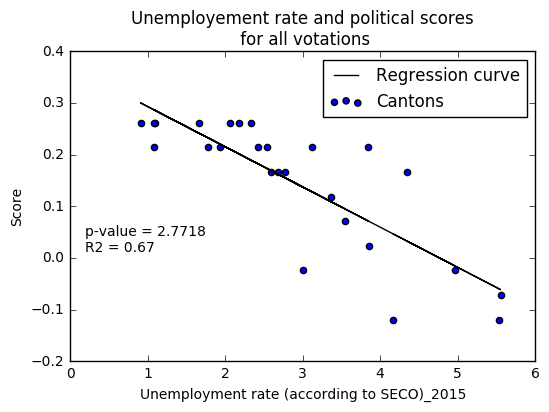

In [85]:
# chose the parameter to plot among the significant ones
i=11
#define x and y

x=np.array(demographics_clean[significant_features[i]])
y=np.array(scores_party['All votations'])

#fit a linear regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
abline_values = [slope * i + intercept for i in x]

fig, ax = plt.subplots()
ax.scatter(x, y)
plt.plot(x, abline_values, 'k')
plt.xlabel(significant_features[i])
#plt.xlabel('')
plt.ylabel('Score')
plt.legend(['Regression curve','Cantons'],loc='upper right')
plt.figtext(0.15, 0.4, 'p-value = '+ str(p_value)[0:6]+'\nR2 = '+ str(r_value**2)[0:4] )

plt.title('Unemployement rate and political scores\n for all votations')
#fig.savefig('unemployement_politicalscore.eps', format='eps')

More correlations visualisations can be found in the Figure folder, in the subfolder correlations.

### Linear regression for the different votations categories

We computed the linear regression coefficients also for the significant correlations between the demogrphics and the scores for the votations of each category.

In [88]:
scores_party.columns

Index(['All votations', 'Economie', 'Education', 'Environnement',
       'Immigration', 'Sante', 'Securite', 'Social', 'Travail'],
      dtype='object')

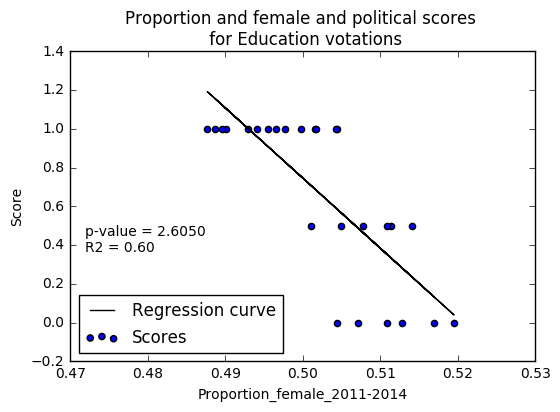

In [89]:
#define x and y

x=np.array(demographics_clean[significant_features[i]])
y=np.array(scores_party['Securite'])

#fit a linear regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
abline_values = [slope * i + intercept for i in x]

fig, ax = plt.subplots()
ax.scatter(x, y)
plt.plot(x, abline_values, 'k')
plt.xlabel(significant_features[i])
plt.ylabel('Score')
plt.legend(['Regression curve','Scores'],loc='lower left')
plt.figtext(0.15, 0.4, 'p-value = '+ str(p_value)[0:6]+'\nR2 = '+ str(r_value**2)[0:4] )

plt.title('Proportion and female and political scores \n for Education votations')

Due to scores often spread in 2 or 3 values only for each votation categories this type of representation is not optimal to show the influence of one parameter on the tendency of vote of each cantons.

Here we can still see that when the proportion of female in the popualtion, the outcome of the votations concerning education follows more the left recommendations

### GLM to test all the parameters at once and find % of variance explained

So far we tested all the features independently. But it is also interesting to test a regression that has all of these parameters together.

We used a GLM to predict the scores (for all votations together) from the significant features.

In [90]:
x=np.array(demographics_clean[significant_features]).astype(float)
y=np.array(scores_party['All votations']).astype(float)

In [91]:
import statsmodels.api as sm
x= sm.add_constant(x, prepend=False)

In [92]:
glm_binom = sm.GLM(y, x, family=sm.families.Gaussian(sm.families.links.log))
res = glm_binom.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   26
Model:                            GLM   Df Residuals:                        8
Model Family:                Gaussian   Df Model:                           17
Link Function:                    log   Scale:                0.00641625793487
Method:                          IRLS   Log-Likelihood:                 37.744
Date:                Thu, 02 Feb 2017   Deviance:                     0.051330
Time:                        18:07:19   Pearson chi2:                   0.0513
No. Iterations:                   100                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1         -1.051e-05      0.000     -0.021      0.983        -0.001     0.001
x2             0.1281      0.189      0.678      0.4

In [93]:
means = x.mean(axis=0)
means25 = means.copy()
means25[0] = stats.scoreatpercentile(x[:,0], 25)
means75 = means.copy()
means75[0] = lowinc_75per = stats.scoreatpercentile(x[:,0], 75)
resp_25 = res.predict(means25)
resp_75 = res.predict(means75)
diff = resp_75 - resp_25

In [94]:
from statsmodels.graphics.api import abline_plot


In [95]:
yhat=res.mu

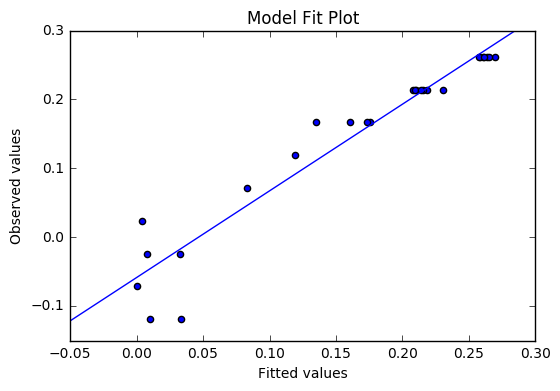

In [96]:
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

The significant features allow a satisfying prediction of the votations outcome for the positive scores (right recommendations) however the prediction for the negative scores is not very good.

The model used here might not be the most appropriated one, we should try some better form of regression.


### Random forest regression to predict the score obtained by each canton from the significant demographics

In [97]:
X=np.array(demographics_clean[significant_features]).astype(float)
y=np.array(scores_party['All votations']).astype(float)
Regressor = RandomForestRegressor()
Regressor.fit(X, y)
y_pred=Regressor.predict(X)
r2=Regressor.score(X, y)
r2

0.92816696113074204

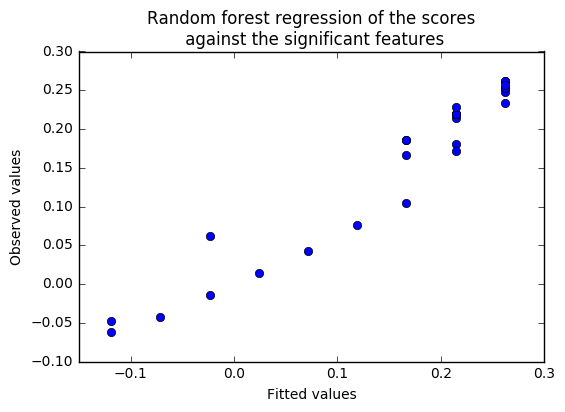

In [105]:
# plot the predicted against the real data
fig= plt.subplot()
plt.plot(y,y_pred, 'o')
plt.title('Random forest regression of the scores\n against the significant features')
plt.ylabel('Observed values')
plt.xlabel('Fitted values');


With a random forest regressor trained on the 17 significant features, the correlation coefficient r2 was of 0.93.
These 17 features are enough to explain most of the variability between the cantons scores

### Random forest classification to predict the outcome of a votation of one category

We can train some classifiers to predict the binary outcome of the votations (Right won: 1, Left won :2 of both won:0)

This is also not optimal because we test the classifier was trained and tested on data that came from the results of several votations pulled together. 

In [110]:
winning_group.head()

,All votations,Economie,Education,Environnement,Immigration,Sante,Securite,Social,Travail
ZH,1,1,1,2,1,1,0,2,1
BE,1,1,1,2,1,1,1,2,1
LU,1,1,1,0,1,1,1,2,1
UR,1,1,1,0,1,1,1,2,1
SZ,1,1,1,0,1,1,1,2,1


In [111]:
mean_acc=[]
std_acc=[]
for i,j in enumerate(winning_group.columns):
    feat=np.array(demographics_clean[significant_features]).astype(float)
    labels=np.array(winning_group[j])
    classifier = RandomForestClassifier(max_depth = None , n_estimators = 100) 

    #classify and compute accuracy
    accuracy, classifier = build_RF(10,feat,labels,classifier)

    # Display accuracy
    mean_acc.append(np.mean(accuracy))
    std_acc.append(np.std(accuracy))

    

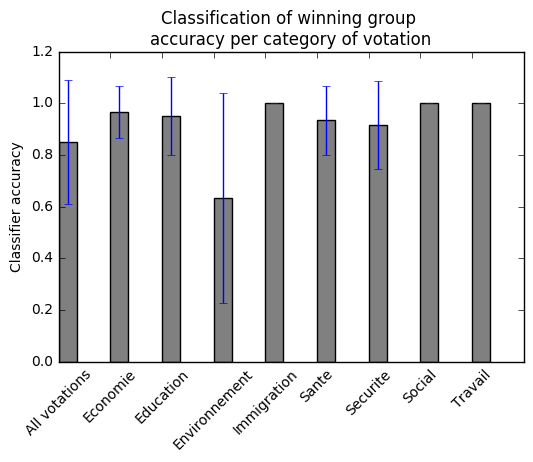

In [112]:
fig, ax = plt.subplots()
ind = np.arange(len(mean_acc))  # the x locations for the groups
width = 0.35 
plt.bar(ind, mean_acc, width, color='grey', yerr=std_acc)
plt.ylabel('Classifier accuracy')
plt.title('Classification of winning group \naccuracy per category of votation')
plt.xticks(ind,winning_group.columns.tolist(), rotation=45)
fig.savefig('../Figures/classifier_eachcategory.eps', format='eps')

As expected , for the votations categories for which the cantons all vote the same, the accuracy of a classifier predicting the outcome is 100% (since the outcome is always the same). For categories that have a more balanced vote such as environment, the accuracy is not very good and we cannot predict the outcome of the votations

### Compute the feature importance of a Random forest train on all the demographics parameters

For this last step the feature importance of a random forest classifier trained on all demographics were studied.
We expect to see the same features than the ones previously identified as significant

In [113]:
#feat=np.array(demographics_clean).astype(float)
feat=np.array(demographics_clean).astype(float)

labels=np.array(winning_group['All votations'])

In [114]:
# Build the classifier with default parameters:
classifier = RandomForestClassifier(max_depth = None , n_estimators = 500) 

#find the index for the features
feat_indexes = demographics_clean.columns.tolist()

#classify and compute accuracy
accuracy, classifier = build_RF(10,feat,labels,classifier)

# Display accuracy
mean_acc=np.mean(accuracy)
std_acc=np.std(accuracy)
print(mean_acc,std_acc)

# Study feature importance
feat_imp = classifier.feature_importances_
n_weights = 10#np.shape(features)[1] # determine number of weights

indices = np.argsort(feat_imp)[::-1]
labels = np.array(feat_indexes)[indices][:n_weights]
print(np.array(feat_indexes)[indices][:n_weights])



0.866666666667 0.30550504633
['Main language in % French_2013' 'Main language in % German_2013'
 'Age distribution in % 0–19_2014' 'Crude marriage rate_2014'
 'Unemployment rate (according to SECO)_2015'
 'Utilised agricultural area per farm in ha_2014'
 'Upper secondary education (aged 25 or over)_2013'
 'Without post-compulsory education (aged 25 or over)_2013'
 'pop_age_total_2011-2014'
 'Share of organic agricultural land in total utilised agricultural area in %_2014']


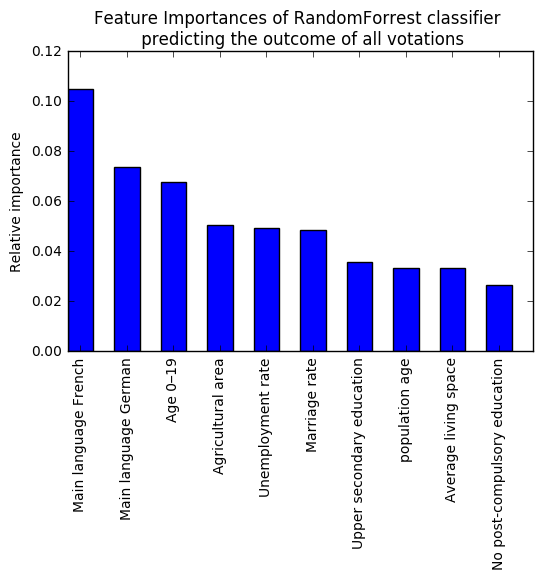

In [115]:
# Plot feature importances
fig=plt.figure()
width = 0.55
ind=np.arange(n_weights)
labels=['Main language French', 'Main language German',
 'Age 0–19',
 'Agricultural area',
 'Unemployment rate', 'Marriage rate',
 'Upper secondary education',
 'population age', 'Average living space',
 'No post-compulsory education']
plt.bar(range(n_weights),feat_imp[indices][:n_weights],width)
plt.ylabel('Relative importance')
plt.title('Feature Importances of RandomForrest classifier \n predicting the outcome of all votations')
plt.xticks(ind+width/ 2, labels, rotation = 'vertical')
plt.gcf().subplots_adjust(bottom=0.15)
fig.savefig('RF_allvotations.png', format='png')

Some of the most important features corresponded to the ones previously identified as significant, but the randomforest al